In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('Heartbeat_Sounds'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Heartbeat_Sounds/set_a.csv
Heartbeat_Sounds/set_a_timing.csv
Heartbeat_Sounds/set_b.csv
Heartbeat_Sounds/set_a/artifact__201012172012.wav
Heartbeat_Sounds/set_a/artifact__201105040918.wav
Heartbeat_Sounds/set_a/artifact__201105041959.wav
Heartbeat_Sounds/set_a/artifact__201105051017.wav
Heartbeat_Sounds/set_a/artifact__201105060108.wav
Heartbeat_Sounds/set_a/artifact__201105061143.wav
Heartbeat_Sounds/set_a/artifact__201105190800.wav
Heartbeat_Sounds/set_a/artifact__201105280851.wav
Heartbeat_Sounds/set_a/artifact__201106010559.wav
Heartbeat_Sounds/set_a/artifact__201106010602.wav
Heartbeat_Sounds/set_a/artifact__201106021541.wav
Heartbeat_Sounds/set_a/artifact__201106030612.wav
Heartbeat_Sounds/set_a/artifact__201106031558.wav
Heartbeat_Sounds/set_a/artifact__201106040722.wav
Heartbeat_Sounds/set_a/artifact__201106040933.wav
Heartbeat_Sounds/set_a/artifact__201106040947.wav
Heartbeat_Sounds/set_a/artifact__201106041452.wav
Heartbeat_Sounds/set_a/artifact__201106050353.wav
Heartbeat_So

In [2]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2024-03-28 00:40:25.690689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-28 00:40:25.690836: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
dataset = []
for folder in ["Heartbeat_Sounds/set_a/**","Heartbeat_Sounds/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        
                        dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })
                       
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 168 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1441 non-null   object 
 1   label     1441 non-null   object 
 2   offset    1441 non-null   float64
dtypes: float64(1), object(2)
memory usage: 45.0+ KB


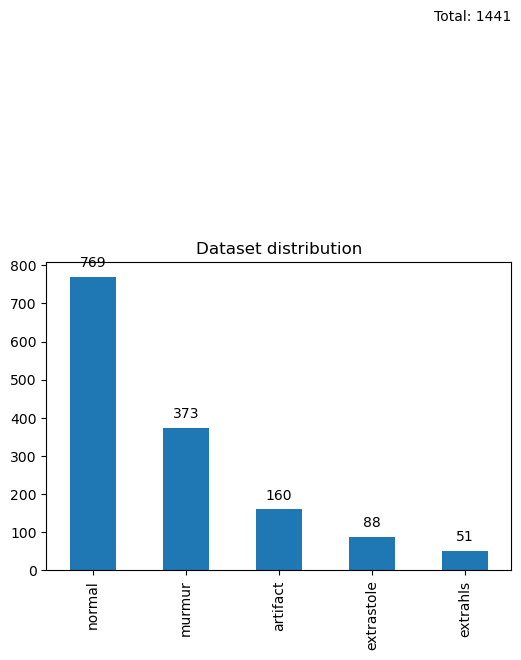

In [41]:
import matplotlib.pyplot as plt

# Tính tổng số lượng mẫu cho mỗi nhãn
label_counts = dataset.label.value_counts()

# Tạo biểu đồ
plt.figure(figsize=(6,4))
ax = label_counts.plot(kind='bar', title="Dataset distribution")

# Thêm số liệu lên từng cột
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Tính và thêm tổng số mẫu
total = label_counts.sum()
plt.text(len(label_counts)-0.5, total, f'Total: {total}', ha='right')

plt.show()


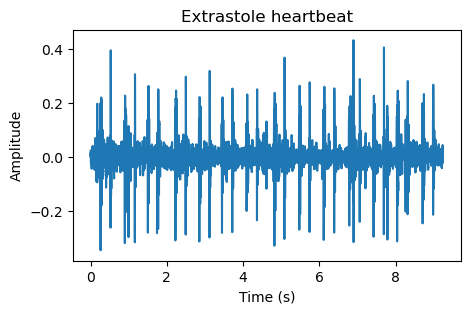

In [39]:
import librosa 
import numpy as np
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio

# Load audio file
audio, sr = librosa.load('Heartbeat_Sounds/set_b/extrastole__128_1306344005749_A.wav', sr=None)

# Calculate time array for plotting
time = np.arange(len(audio)) / sr

# Plot audio waveform
plt.figure(figsize=(5, 3))
plt.plot(time, audio)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Extrastole heartbeat')
plt.show()

# Play audio
Audio(data=audio, rate=sr)


In [5]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1152
Test: 289


In [8]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [9]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 289/289 [00:24<00:00, 11.72it/s]


X train: (1152, 40, 130)
X test: (289, 40, 130)


In [10]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train),
                                        y = y_train )

In [11]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1152, 40, 130, 1)
Y train: (1152, 5)
X test: (289, 40, 130, 1)
Y test: (289, 5)


In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

2024-01-05 11:19:27.223700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-05 11:19:27.224178: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-05 11:19:27.224254: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-0MK0TTK): /proc/driver/nvidia/version does not exist
2024-01-05 11:19:27.228056: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 129, 32)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 63, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 31, 64)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 31, 64)         0

In [13]:
 from tensorflow import keras
adam = keras.optimizers.Adam(1e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [14]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/300
9/9 [==============================] - 11s 1s/step - loss: 6.2965 - accuracy: 0.4462 - val_loss: 1.8364 - val_accuracy: 0.5398
Epoch 2/300
9/9 [==============================] - 10s 1s/step - loss: 2.5360 - accuracy: 0.4931 - val_loss: 1.4214 - val_accuracy: 0.5606
Epoch 3/300
9/9 [==============================] - 12s 1s/step - loss: 1.4565 - accuracy: 0.5564 - val_loss: 1.1290 - val_accuracy: 0.5952
Epoch 4/300
9/9 [==============================] - 11s 1s/step - loss: 1.0421 - accuracy: 0.5946 - val_loss: 1.2533 - val_accuracy: 0.5813
Epoch 5/300
9/9 [==============================] - 9s 995ms/step - loss: 0.8970 - accuracy: 0.6372 - val_loss: 1.2470 - val_accuracy: 0.5848
Epoch 6/300
9/9 [==============================] - 9s 1s/step - loss: 0.8485 - accuracy: 0.6476 - val_loss: 1.1198 - val_accuracy: 0.6678
Epoch 7/300
9/9 [==============================] - 12s 1s/step - loss: 0.7939 - accuracy: 0.6892 - val_loss: 1.0966 - val_accuracy: 0.6817
Epoch 8/300
9/9 [=========

9/9 [==============================] - 9s 986ms/step - loss: 0.2234 - accuracy: 0.9123 - val_loss: 0.4187 - val_accuracy: 0.8512
Epoch 118/300
9/9 [==============================] - 9s 1s/step - loss: 0.2277 - accuracy: 0.9149 - val_loss: 0.4125 - val_accuracy: 0.8408
Epoch 119/300
9/9 [==============================] - 9s 928ms/step - loss: 0.2155 - accuracy: 0.9280 - val_loss: 0.4016 - val_accuracy: 0.8512
Epoch 120/300
9/9 [==============================] - 10s 1s/step - loss: 0.2404 - accuracy: 0.9062 - val_loss: 0.4635 - val_accuracy: 0.8304
Epoch 121/300
9/9 [==============================] - 10s 1s/step - loss: 0.2548 - accuracy: 0.8941 - val_loss: 0.5066 - val_accuracy: 0.8374
Epoch 122/300
9/9 [==============================] - 9s 957ms/step - loss: 0.2865 - accuracy: 0.8906 - val_loss: 0.4049 - val_accuracy: 0.8478
Epoch 123/300
9/9 [==============================] - 9s 1s/step - loss: 0.2452 - accuracy: 0.9019 - val_loss: 0.4200 - val_accuracy: 0.8512
Epoch 124/300
9/9 [====

9/9 [==============================] - 9s 948ms/step - loss: 0.1027 - accuracy: 0.9609 - val_loss: 0.4573 - val_accuracy: 0.8547
Epoch 176/300
9/9 [==============================] - 10s 1s/step - loss: 0.0749 - accuracy: 0.9714 - val_loss: 0.4574 - val_accuracy: 0.8685
Epoch 177/300
9/9 [==============================] - 9s 1s/step - loss: 0.1042 - accuracy: 0.9592 - val_loss: 0.3963 - val_accuracy: 0.8720
Epoch 178/300
9/9 [==============================] - 9s 974ms/step - loss: 0.1127 - accuracy: 0.9583 - val_loss: 0.4153 - val_accuracy: 0.8616
Epoch 179/300
9/9 [==============================] - 11s 1s/step - loss: 0.1062 - accuracy: 0.9635 - val_loss: 0.4038 - val_accuracy: 0.8547
Epoch 180/300
9/9 [==============================] - 9s 1s/step - loss: 0.1120 - accuracy: 0.9609 - val_loss: 0.4388 - val_accuracy: 0.8685
Epoch 181/300
9/9 [==============================] - 8s 954ms/step - loss: 0.1242 - accuracy: 0.9549 - val_loss: 0.4114 - val_accuracy: 0.8720
Epoch 182/300
9/9 [====

Epoch 233/300
9/9 [==============================] - 8s 947ms/step - loss: 0.0497 - accuracy: 0.9818 - val_loss: 0.3877 - val_accuracy: 0.8824
Epoch 234/300
9/9 [==============================] - 8s 863ms/step - loss: 0.0524 - accuracy: 0.9835 - val_loss: 0.4980 - val_accuracy: 0.8685
Epoch 235/300
9/9 [==============================] - 7s 772ms/step - loss: 0.0504 - accuracy: 0.9826 - val_loss: 0.4148 - val_accuracy: 0.8685
Epoch 236/300
9/9 [==============================] - 8s 871ms/step - loss: 0.0497 - accuracy: 0.9835 - val_loss: 0.3774 - val_accuracy: 0.8789
Epoch 237/300
9/9 [==============================] - 8s 854ms/step - loss: 0.0610 - accuracy: 0.9722 - val_loss: 0.4183 - val_accuracy: 0.8789
Epoch 238/300
9/9 [==============================] - 7s 823ms/step - loss: 0.0551 - accuracy: 0.9757 - val_loss: 0.4611 - val_accuracy: 0.8858
Epoch 239/300
9/9 [==============================] - 8s 864ms/step - loss: 0.0624 - accuracy: 0.9705 - val_loss: 0.3978 - val_accuracy: 0.8824

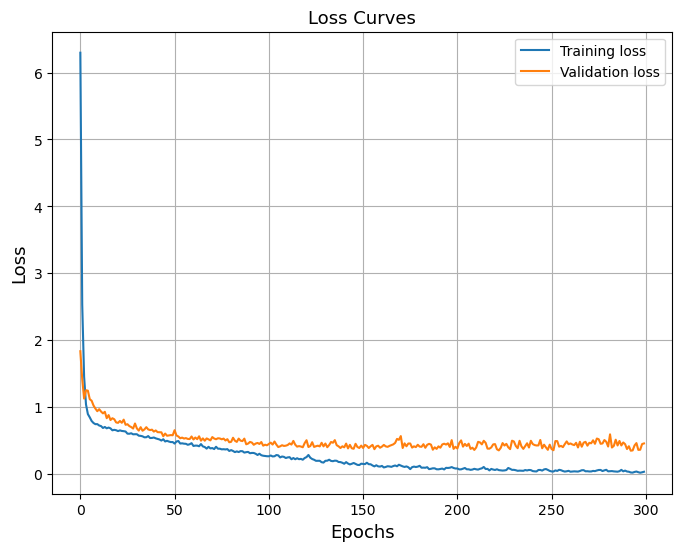

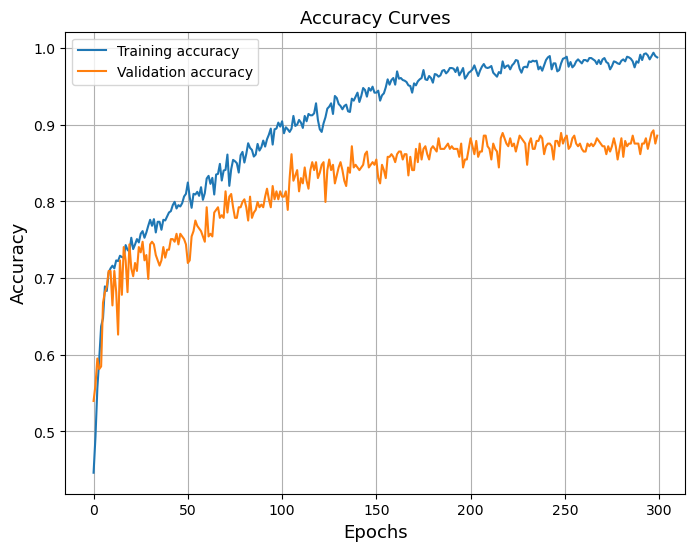

In [16]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss and accuracy curves for training and validation metrics.
    Args:
        history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel('Epochs', fontsize=13)
    plt.ylabel('Loss', fontsize=13)
    plt.title('Loss Curves', fontsize=13)
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    plt.xlabel('Epochs', fontsize=13)
    plt.ylabel('Accuracy', fontsize=13)
    plt.title('Accuracy Curves', fontsize=13)
    plt.legend()
    plt.grid(True)

# Sử dụng hàm này với đối tượng history của mô hình
plot_loss_curves(history)


In [17]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10/10 [==============================] - 1s 73ms/step - loss: 0.4587 - accuracy: 0.8858
Test loss: 0.45870429277420044
Test accuracy: 0.8858131766319275


In [18]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

10/10 [==============================] - 2s 55ms/step
              precision    recall  f1-score   support

    artifact       0.97      1.00      0.99        33
    extrahls       0.71      0.67      0.69        15
  extrastole       0.72      0.81      0.76        16
      murmur       0.85      0.92      0.88        75
      normal       0.92      0.87      0.90       150

    accuracy                           0.89       289
   macro avg       0.84      0.85      0.84       289
weighted avg       0.89      0.89      0.89       289



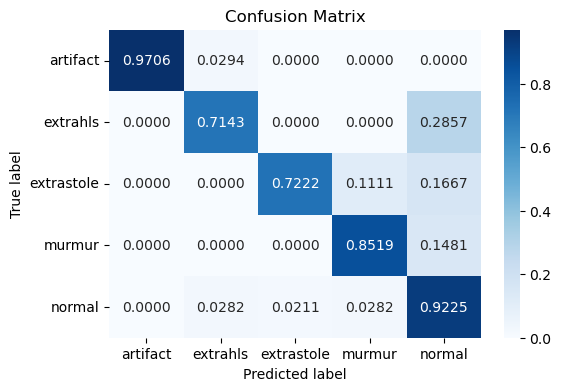

In [22]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Class names
class_names = ['artifact', 'extrahls', 'extrastole', 'murmur', 'normal']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by dividing each row by its sum
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Function to plot the confusion matrix
def plot_confusion_matrix(cm_normalized, class_names, figsize=(6, 4), fmt='.4f'):
    plt.figure(figsize=figsize)
    sns.heatmap(cm_normalized, annot=True, fmt=fmt, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)
    plt.show()

# Plot the normalized confusion matrix with class names
class_names = encoder.classes_
plot_confusion_matrix(cm_normalized, class_names)


In [43]:
model_name = "heart_sound_2dcnn.h5"
model.save(model_name)